## Imports

In [18]:
import os
import shutil
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras import Input, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from pyMLaux import show_img_data, plot_history, evaluate_regression_result

import tensorflow_hub as hub

## Load Data

In [20]:
pizza_dir = './data/input/pizza_not_pizza/pizza' 
not_pizza_dir = './data/input/pizza_not_pizza/not_pizza'
data_dir = './data/input/pizza_not_pizza'
test_dir = './data/input/pizza_not_pizza_test'
pizza_test_dir = './data/input/pizza_not_pizza_test/pizza'
not_pizza_test_dir = './data/input/pizza_not_pizza_test/not_pizza'

AI_pizza_dir = r'C:\Users\jakob\Desktop\COV-AI\pizza_not_pizza\pizza' 
AI_not_pizza_dir = r'C:\Users\jakob\Desktop\COV-AI\pizza_not_pizza\not_pizza'
AI_data_dir = r'C:\Users\jakob\Desktop\COV-AI\pizza_not_pizza'



In [21]:
num_pizza_images = len(os.listdir(pizza_dir))
num_non_pizza_images = len(os.listdir(not_pizza_dir))
num_test_pizza = len(os.listdir(pizza_test_dir))
num_test_non_pizza = len(os.listdir(not_pizza_test_dir))

print(f'Number of Pizza images: {num_pizza_images}')
print(f'Number of Non-Pizza images: {num_non_pizza_images}')
print(f'Number of Pizza test images: {num_test_pizza}')
print(f'Number of Non-Pizza test images: {num_test_non_pizza}')



Number of Pizza images: 908
Number of Non-Pizza images: 908
Number of Pizza test images: 75
Number of Non-Pizza test images: 75


# Original Data

## Train/Validation/Test Data Sets

In [22]:
batch_size = 32

data_gen = ImageDataGenerator(rescale = 1/255., validation_split = 0.2)

train_data = data_gen.flow_from_directory(data_dir, 
                                          target_size = (224, 224), 
                                          batch_size = batch_size,
                                          subset = 'training',
                                          class_mode = 'binary')
val_data = data_gen.flow_from_directory(data_dir, 
                                        target_size = (224, 224), 
                                        batch_size = batch_size,
                                        subset = 'validation',
                                        class_mode = 'binary')
test_data = data_gen.flow_from_directory(test_dir, 
                                         target_size = (224, 224), 
                                         batch_size = batch_size,
                                         class_mode = 'binary')

Found 1454 images belonging to 2 classes.
Found 362 images belonging to 2 classes.
Found 150 images belonging to 2 classes.


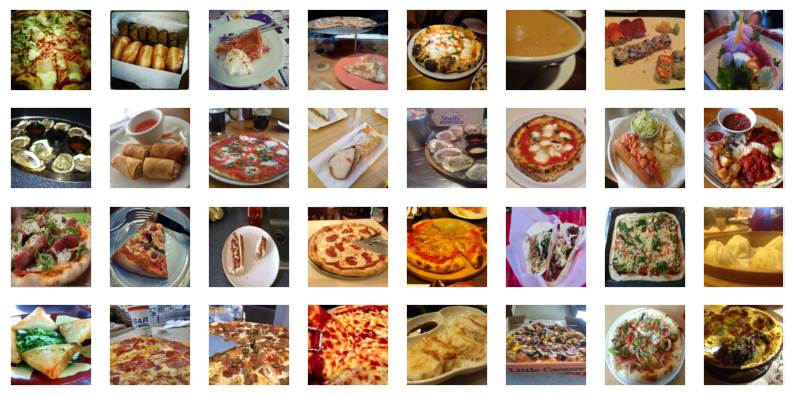

In [23]:
for image_batch, label_batch in train_data:
    show_img_data(image_batch, no=batch_size, layout=(8, 8), figsize=(10, 10))
    
    break



## Baseline Model

In [6]:
tf.random.set_seed(42)
model_1 = Sequential([
    Input(shape = (224, 224, 3)), # Input layer    
    Conv2D(filters = 32, kernel_size = 2, padding = 'valid', activation = 'relu'), # First Convolutional layer
    Conv2D(filters = 32, kernel_size = 2, padding = 'valid', activation = 'relu'), # Second Convolutional layer
    Flatten(),
    Dense(1, activation = 'sigmoid') # Output layer  
])

model_1.compile(loss = BinaryCrossentropy(),
                optimizer = Adam(),
                metrics = ['accuracy'])



In [7]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 223, 223, 32)      416       
                                                                 
 conv2d_1 (Conv2D)           (None, 222, 222, 32)      4128      
                                                                 
 flatten (Flatten)           (None, 1577088)           0         
                                                                 
 dense (Dense)               (None, 1)                 1577089   
                                                                 
Total params: 1581633 (6.03 MB)
Trainable params: 1581633 (6.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Train Model

In [8]:
model_filepath = './data/cnn_models/pizza-not-pizza_cnn1.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_filepath, monitor='val_accuracy', verbose=1,
                                                save_best_only=True, mode='max', save_weights_only=False)
callbacks_list = [checkpoint]

history_1 = model_1.fit(train_data,
                        epochs= 5,
                        steps_per_epoch = len(train_data),
                        validation_data = val_data,
                        validation_steps = len(val_data),
                        callbacks=callbacks_list)



Epoch 1/5


46/46 [==============================] - ETA: 0s - loss: 6.8721 - accuracy: 0.5158
Epoch 1: val_accuracy improved from -inf to 0.49448, saving model to ./data/cnn_models\pizza-not-pizza_cnn1.hdf5
46/46 [==============================] - 34s 704ms/step - loss: 6.8721 - accuracy: 0.5158 - val_loss: 0.6930 - val_accuracy: 0.4945
Epoch 2/5
46/46 [==============================] - ETA: 0s - loss: 0.6749 - accuracy: 0.5468
Epoch 2: val_accuracy improved from 0.49448 to 0.51657, saving model to ./data/cnn_models\pizza-not-pizza_cnn1.hdf5
46/46 [==============================] - 33s 722ms/step - loss: 0.6749 - accuracy: 0.5468 - val_loss: 0.6817 - val_accuracy: 0.5166
Epoch 3/5
46/46 [==============================] - ETA: 0s - loss: 0.5777 - accuracy: 0.6912
Epoch 3: val_accuracy improved from 0.51657 to 0.60221, saving model to ./data/cnn_models\pizza-not-pizza_cnn1.hdf5
46/46 [==============================] - 32s 700ms/step - loss: 0.5777 - accuracy: 0.6912 - val_loss: 0.6680 -

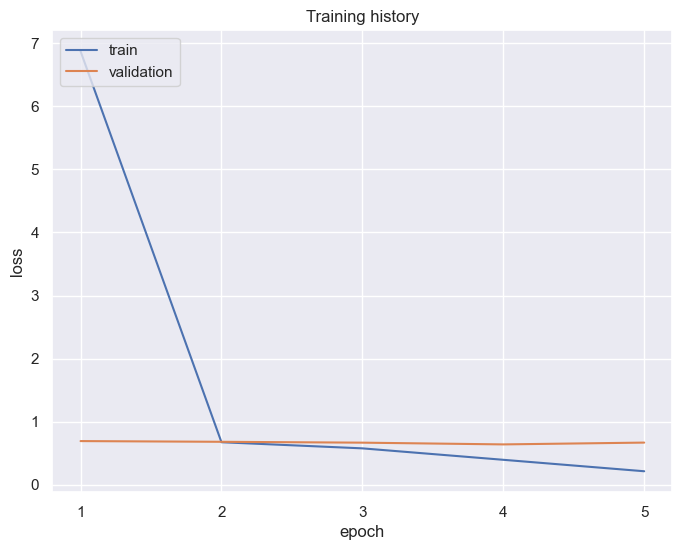

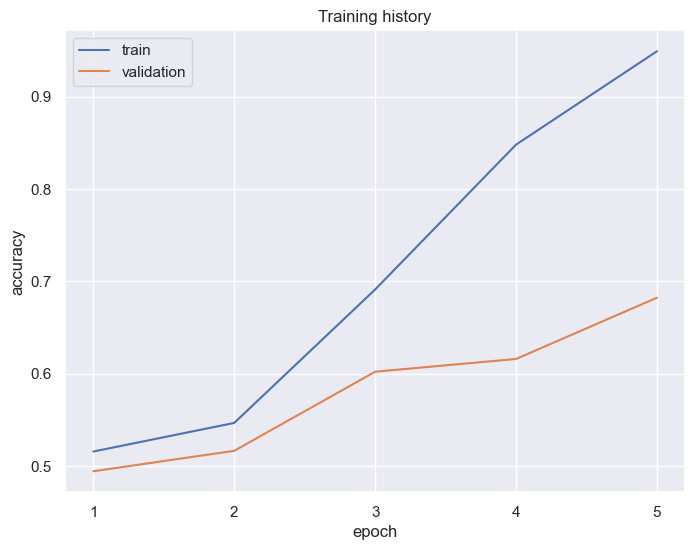

In [9]:
plot_history(history_1)

In [10]:
# Evaluate the model on the test data

model = tf.keras.models.load_model(model_filepath)

test_loss, test_acc = model.evaluate(test_data)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_acc}")

5/5 [==============================] - 1s 128ms/step - loss: 0.5994 - accuracy: 0.7067
Test loss: 0.5994453430175781
Test accuracy: 0.7066666483879089


## Improving the Model

There are lot of things we can change for improving the model such as:

    Increasing the number of epochs
    Adding Max Pooling Layer
    Adding more convolutional layers
    Changing the number of filters
    Changing the size of our filters
    Changing the pool size of Max Pooling layer



In [11]:
model_2 = Sequential([
    Input(shape = (224, 224, 3)),
    Conv2D(filters = 10, kernel_size = 2, padding = 'valid', activation = 'relu'),
    MaxPool2D(pool_size = 2),
    Conv2D(filters = 32, kernel_size = 2, padding = 'valid', activation = 'relu'),
    MaxPool2D(pool_size = 2),
    Conv2D(filters = 64, kernel_size = 2, padding = 'valid', activation = 'relu'),
    MaxPool2D(pool_size = 2),
    Flatten(),
    Dense(1, activation = 'sigmoid')
])

model_2.compile(loss = BinaryCrossentropy(),
                optimizer = Adam(learning_rate = 0.0001),
                metrics = ['accuracy'])



In [12]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 223, 223, 10)      130       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 10)      0         
 D)                                                              
                                                                 
 conv2d_3 (Conv2D)           (None, 110, 110, 32)      1312      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 55, 55, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 54, 54, 64)        8256      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 27, 27, 64)       

In [13]:
model_filepath = './data/cnn_models/pizza-not-pizza_cnn2.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_filepath, monitor='val_accuracy', verbose=1,
                                                save_best_only=True, mode='max', save_weights_only=False)
callbacks_list = [checkpoint]

history_2 = model_2.fit(train_data,
                        epochs= 20,
                        steps_per_epoch = len(train_data),
                        validation_data = val_data,
                        validation_steps = len(val_data),
                        callbacks=callbacks_list)

Epoch 1/20
46/46 [==============================] - ETA: 0s - loss: 0.6948 - accuracy: 0.5213
Epoch 1: val_accuracy improved from -inf to 0.62707, saving model to ./data/cnn_models\pizza-not-pizza_cnn2.hdf5
46/46 [==============================] - 11s 226ms/step - loss: 0.6948 - accuracy: 0.5213 - val_loss: 0.6663 - val_accuracy: 0.6271
Epoch 2/20
46/46 [==============================] - ETA: 0s - loss: 0.6558 - accuracy: 0.6376
Epoch 2: val_accuracy improved from 0.62707 to 0.68508, saving model to ./data/cnn_models\pizza-not-pizza_cnn2.hdf5
46/46 [==============================] - 10s 222ms/step - loss: 0.6558 - accuracy: 0.6376 - val_loss: 0.6345 - val_accuracy: 0.6851
Epoch 3/20
46/46 [==============================] - ETA: 0s - loss: 0.6277 - accuracy: 0.6664
Epoch 3: val_accuracy improved from 0.68508 to 0.72652, saving model to ./data/cnn_models\pizza-not-pizza_cnn2.hdf5
46/46 [==============================] - 10s 226ms/step - loss: 0.6277 - accuracy: 0.6664 - val_loss: 0.6016 

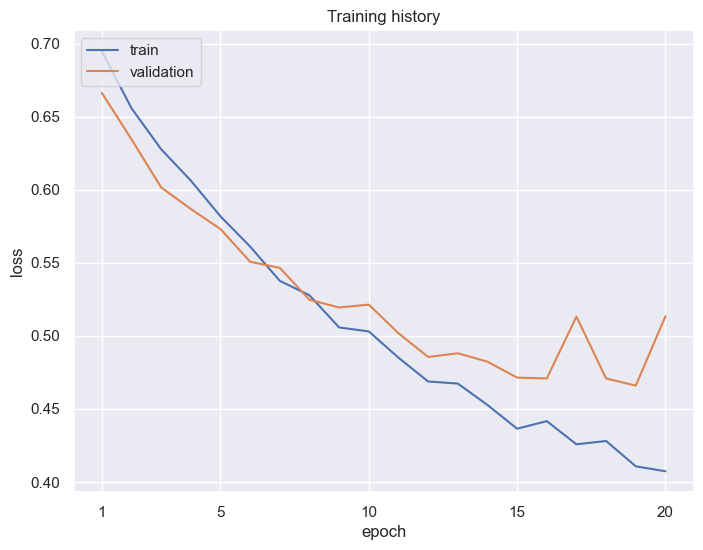

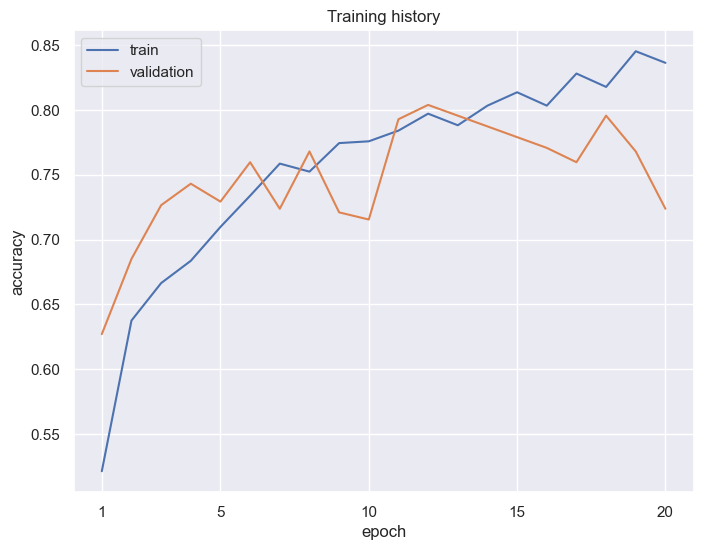

In [14]:
plot_history(history_2)

In [15]:
# Evaluate the model on the test data

model = tf.keras.models.load_model(model_filepath)

test_loss, test_acc = model.evaluate(test_data)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_acc}")

5/5 [==============================] - 1s 105ms/step - loss: 0.5300 - accuracy: 0.7400
Test loss: 0.5299704074859619
Test accuracy: 0.7400000095367432


# AI Data

## AI Data Train/Validation Data Sets

In [27]:
AI_num_pizza_images = len(os.listdir(AI_pizza_dir))
AI_non_pizza_images = len(os.listdir(AI_not_pizza_dir))
print(f'Number of Generated Pizza images: {AI_num_pizza_images}')
print(f'Number of Generated Non-Pizza images: {AI_non_pizza_images}')

Number of Generated Pizza images: 1050
Number of Generated Non-Pizza images: 1001


In [28]:
batch_size = 32

data_gen = ImageDataGenerator(rescale = 1/255., validation_split = 0.2)

AI_train_data = data_gen.flow_from_directory(AI_data_dir, 
                                          target_size = (224, 224), 
                                          batch_size = batch_size,
                                          subset = 'training',
                                          class_mode = 'binary')
AI_val_data = data_gen.flow_from_directory(AI_data_dir, 
                                        target_size = (224, 224), 
                                        batch_size = batch_size,
                                        subset = 'validation',
                                        class_mode = 'binary')


Found 1641 images belonging to 2 classes.
Found 410 images belonging to 2 classes.


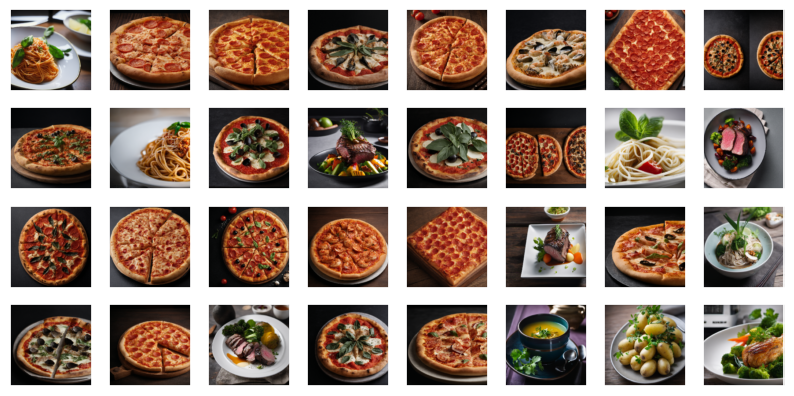

In [29]:
for image_batch, label_batch in AI_train_data:
    show_img_data(image_batch, no=batch_size, layout=(8, 8), figsize=(10, 10))
    
    break



In [35]:
model_3 = Sequential([
    Input(shape = (224, 224, 3)),
    Conv2D(filters = 10, kernel_size = 2, padding = 'valid', activation = 'relu'),
    MaxPool2D(pool_size = 2),
    Conv2D(filters = 32, kernel_size = 2, padding = 'valid', activation = 'relu'),
    MaxPool2D(pool_size = 2),
    Conv2D(filters = 64, kernel_size = 2, padding = 'valid', activation = 'relu'),
    MaxPool2D(pool_size = 2),
    Flatten(),
    Dense(1, activation = 'sigmoid')
])

model_3.compile(loss = BinaryCrossentropy(),
                optimizer = Adam(learning_rate = 0.0001),
                metrics = ['accuracy'])



In [36]:
model_3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 223, 223, 10)      130       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 111, 111, 10)      0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 110, 110, 32)      1312      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 55, 55, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 54, 54, 64)        8256      
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 27, 27, 64)       

In [39]:
model_filepath = './data/cnn_models/pizza-not-pizza_cnn_AI.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_filepath, monitor='val_accuracy', verbose=1,
                                                save_best_only=True, mode='max', save_weights_only=False)

callbacks_list = [checkpoint]


history_3 = model_3.fit(AI_train_data, # using generated data
                        epochs= 20,
                        steps_per_epoch = len(AI_train_data),
                        validation_data = AI_val_data,
                        validation_steps = len(AI_val_data),
                        callbacks=callbacks_list)

Epoch 1/20
52/52 [==============================] - ETA: 0s - loss: 0.0023 - accuracy: 1.0000
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to ./data/cnn_models\pizza-not-pizza_cnn_AI.hdf5
52/52 [==============================] - 83s 2s/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 9.5788e-04 - val_accuracy: 1.0000
Epoch 2/20
52/52 [==============================] - ETA: 0s - loss: 0.0020 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 1.00000
52/52 [==============================] - 82s 2s/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 8.1218e-04 - val_accuracy: 1.0000
Epoch 3/20
52/52 [==============================] - ETA: 0s - loss: 0.0020 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 1.00000
52/52 [==============================] - 84s 2s/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 6.7798e-04 - val_accuracy: 1.0000
Epoch 4/20
52/52 [==============================] - ETA: 0s - loss: 0.0023 - accuracy: 1.0000
Epoch 4:

In [38]:
# Evaluate the model on the test data

model = tf.keras.models.load_model(model_filepath)

test_loss, test_acc = model.evaluate(test_data)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_acc}")

5/5 [==============================] - 1s 102ms/step - loss: 1.6180 - accuracy: 0.5733
Test loss: 1.618048906326294
Test accuracy: 0.5733333230018616
